In [1]:
from util import *

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
Add path ../../..
Connected DB


In [2]:
import os
import numpy as np

In [3]:
import matplotlib.image as mpimg

In [4]:
from IPython.display import HTML

# NAMESPACE

In [5]:
class NAMESPACE:
    # Base values
    TABLE_NAME = 'DATA_RPT_CARD_493'
    SEL_SAMPLE = 'SAMPLE1_SUB3'
    
    # Important to look
    QUERY = f"""SELECT X.* FROM DW_ANALYTICS.{TABLE_NAME} X JOIN CINS_TMP_ALY_CUST_{SEL_SAMPLE} SAM ON X.CUSTOMER_CDE = SAM.CUSTOMER_CDE"""
    
    # Derived values
    data_fp = f'./data/{TABLE_NAME}'
    data_sample_nm = os.path.join(data_fp, SEL_SAMPLE)
    IMG_FP = f'./img/{TABLE_NAME}'
    img = f'./img/{TABLE_NAME}/{SEL_SAMPLE}'
    
    def show():
        atts = dir(NAMESPACE)
        for a in atts:
            if not a.startswith('__'):
                print(a)
    
    @classmethod
    def init(cls):
        if not os.path.exists(NAMESPACE.data_fp):
            os.makedirs(NAMESPACE.data_fp)
        if not os.path.exists(NAMESPACE.img):
            os.makedirs(NAMESPACE.img)

In [6]:
NAMESPACE.QUERY

'SELECT X.* FROM DW_ANALYTICS.DATA_RPT_CARD_493 X JOIN CINS_TMP_ALY_CUST_SAMPLE1_SUB3 SAM ON X.CUSTOMER_CDE = SAM.CUSTOMER_CDE'

In [7]:
NAMESPACE.init()

In [8]:
NAMESPACE.show()

IMG_FP
QUERY
SEL_SAMPLE
TABLE_NAME
data_fp
data_sample_nm
img
init
show


In [9]:
stat_opt = [
            'count',
            'mean',
            'median',
            'min',
            'max',
            'std',
]
ordered_stat_opt = [[i, i + '_pct_chg'] for i in stat_opt]
ordered_stat_opt = [j for i in ordered_stat_opt for j in i]

# Functions

In [10]:
def aly_datetime(df, date_col, cde_col, resample='1Y', outlier_date='1930-01-01', timedelta='365 days',lvl=3):
    display(HTML(f'<h{lvl}>{date_col}</h{lvl}>'))
    if cde_col is None:
        tmp_df = df[date_col].copy()
        tmp_df[date_col] = pd.to_datetime(tmp_df[date_col], errors='coerce')
        tmp_df[date_col] = df[date_col].astype('datetime64[D]')
        tmp = tmp_df[tmp_df[date_col] > outlier_date]
        plot_df = tmp.set_index(date_col).resample(resample).nunique()
    else:
        tmp_df = df[[date_col, cde_col]].copy()
        tmp_df[date_col] = pd.to_datetime(tmp_df[date_col], errors='coerce')
        tmp_df[date_col] = df[date_col].astype('datetime64[D]')
        tmp = tmp_df[tmp_df[date_col] > outlier_date]
        plot_df = tmp.set_index(date_col)[cde_col].resample(resample).nunique()
    
    fig, axs = plt.subplots(1,2, figsize=(15, 5))
    plot_df.plot(kind='bar', rot=70, ax=axs[0])
    up2now = ((datetime(2023,11,1) - tmp[date_col]) / pd.Timedelta(timedelta)).apply(float)
    sns.histplot(up2now, kde=True, ax=axs[1])

In [11]:
def default_func(x):
    return x

In [12]:
def remove_mode_value(x):
    return x[~x.isin(x.mode().values)]

In [13]:
def logx(x):
    return np.log(x)

In [14]:
def plot_multi_hist_aly(df,cols=[],funcs=[default_func, remove_mode_value, logx], lvl=3):
    def df_stat_after_transformed(df_trans):
        def pct_change(series):
            first_e = series.iloc[0]
            pct_chg = (series - first_e) / first_e * 100
            pct_chg.iloc[0] = 100.
            return pct_chg
        stat_infos = []
        for data_trans_series in df_trans:
            # Get stats info
            stat_info = []
            for s in stat_opt:
                if s == 'count':
                    stat_info.append(data_trans_series.count())
                elif s == 'mean':
                    stat_info.append(data_trans_series.mean())
                elif s == 'median':
                    stat_info.append(data_trans_series.median())
                elif s == 'min':
                    stat_info.append(data_trans_series.min())
                elif s == 'max':
                    stat_info.append(data_trans_series.max())
                elif s == 'std':
                    stat_info.append(data_trans_series.std())
            stat_infos.append(stat_info)
        col_stat = stat_opt
        index_stat = [f.__name__ for f in funcs]
        stat_df = pd.DataFrame(data=stat_infos, columns=col_stat, index=index_stat)
        for c in stat_df.columns:
            stat_df[f'{c}_pct_chg'] = pct_change(stat_df[c])
        stat_df = stat_df[ordered_stat_opt]
        result_df = stat_df.T
        return result_df
    
    nrows, ncols = len(cols), len(funcs)
    for i, c in enumerate(cols):
        display(HTML(f'<h{lvl}>{c}</h{lvl}>'))
        if c in df.columns:
            data_trans = []
            for f in funcs:
                pre_data_tran = data_trans[-1] if len(data_trans) > 0 else df[c]
                trans_data = f(pre_data_tran)
                data_trans.append(trans_data)
            # plot section 
            fig, axs = plt.subplots(1,ncols, figsize=(4* ncols, 4 ))
            for j, d in enumerate(data_trans):
                sel_ax = axs[j]
                sel_ax.set_title(f'{cols[i]}\n{funcs[j].__name__}')
                d.replace([np.inf, -np.inf], np.nan).plot(kind='hist',bins=100,ax=sel_ax)
            pd.options.display.float_format = '{:.3f}'.format
            display(df_stat_after_transformed(data_trans))
            plt.tight_layout()
            plt.savefig(os.path.join(NAMESPACE.img, f'{c}.jpg'), dpi=500)
            plt.show()
            print('\n\n\n')

In [15]:
def aly_cat_col(df,cat_cols,k=10, lvl=3):
    for cat_col in cat_cols: 
        display(HTML(f'<h{lvl}>{cat_col}</h{lvl}>'))
        fig,axs=plt.subplots(1,2,figsize=(10,5))
        display(df[cat_col].value_counts())
        df[cat_col].value_counts()[:k].plot(kind='bar', rot=80,ax=axs[0])
        df[cat_col].value_counts()[:k].plot(kind='pie', autopct='%.2f%%',ax=axs[1])
        plt.savefig(os.path.join(NAMESPACE.img, f'{cat_col}.jpg'), dpi=500)
        plt.show()

In [16]:
def download_or_reload(saved_file):
    if not os.path.exists(saved_file):
        query = NAMESPACE.QUERY
        cur.execute(query)
        result = cur.fetchall()
        column_names = [c[0] for c in cur.description]
        df = pd.DataFrame(result, columns=column_names)
        df.to_pickle(saved_file)
    df = pd.read_pickle(saved_file)
    print(f'Len {len(df)}')
    return df

In [17]:
def gen_info_stats(df):
    def info_stats(c):
        dtype = df[c].dtype
        n = len(df)
        null_pct = (n - df[c].count()) / n
        nunique = df[c].nunique()
        nunique_pct = nunique / n
        unique_values = df[c].unique()[:3]
        return c, null_pct, dtype, nunique, nunique_pct, unique_values

    data_stats = []
    for c in df.columns:
        data_stats.append(info_stats(c))
    data_stats = pd.DataFrame(data=data_stats,columns=['Column', 'Null Pct', 'Dtype', 'Nunique', 'Nunique Pct', 'Sample Unique Value'])
    return data_stats

# Sample1-Sub*

In [18]:
NAMESPACE.QUERY

'SELECT X.* FROM DW_ANALYTICS.DATA_RPT_CARD_493 X JOIN CINS_TMP_ALY_CUST_SAMPLE1_SUB3 SAM ON X.CUSTOMER_CDE = SAM.CUSTOMER_CDE'

In [19]:
df = download_or_reload(NAMESPACE.data_sample_nm)

Len 2154019


In [20]:
df

,CARD_CDE,COMPANY_KEY,COMPANY_CDE,DAY_KEY,SUB_BRANCH_KEY,SUB_BRANCH_CDE,CUSTOMER_KEY,CUSTOMER_CDE,CURRENCY_CDE,PRODUCT_CDE,...,TT_BILLING_CYCLE,PROCDATE,OS_AMT,OS_AMT_LCL,TT_CUSTOMER_NAME,TT_CUSTOMER_ADDR,TT_CARD_NUMBER,PROCESS_DT,TT_LOANBRANCH,INTEREST_RATE
0,3657596593,1,VNI,2020151,244,VN0012635,26794958,1958298,VND,3014,...,22.0,2020-05-30,17748533.0,17748533.0,LY THI BICH THUY,"TRUNG BINH, TUAN TUC H THANH TRI SOC TRANG ...",356480XXXXXX8001,2020-05-30,VN0012635,31.2
1,3616313247,1,VNI,2021088,79,VN0011371,26353885,9481149,VND,1005,...,31.0,2021-03-29,7111774.0,7111774.0,NGUYEN VAN TUAN,"20/4D KP 2, P. TAM HOA BIEN HOA DONG NAI ...",472074XXXXXX6692,2021-03-29,VN0011371,31.2
2,3601818432,1,VNI,2020212,248,VN0012663,30940521,7560855,VND,4213,...,25.0,2020-07-30,24517343.0,24517343.0,DOAN THANH QUI,"1560/23/5A TINH LO 10, KP. 2, TAN TAO Q BINH...",436438XXXXXX5094,2020-07-30,VN0012663,28.8
3,3669260824,1,VNI,2020212,154,VN0012247,33819949,4619425,VND,1026,...,22.0,2020-07-30,302665.0,302665.0,PHAM ANH VU,"KP. THANH SON, THI TRAN PHUOC BUU H XUYEN MO...",472074XXXXXX2993,2020-07-30,VN0012247,28.4
4,3753037732,1,VNI,2020212,1,VN0010001,32464762,7367632,VND,3004,...,22.0,2020-07-30,24432851.0,24432851.0,LE THANH DAI,"201/48/2 NGUYEN XI, P. 26 Q BINH THANH HO CH...",356480XXXXXX4993,2020-07-30,VN0010001,31.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154014,3091495063,1,VNI,2022181,462,VN0014007,44361652,39212,VND,5110,...,15.0,2022-06-30,15000000.0,15000000.0,PHAM THI TUYET TRAM,"70 LE CONG PHEP, P. AN LAC Q BINH TAN HO CHI...",526830XXXXXX3990,2022-06-30,VN0014007,31.2
2154015,3547229462,1,VNI,2022181,373,VN0011822,43504255,3389140,VND,3024,...,25.0,2022-06-30,36996668.0,36996668.0,LUU MY TRINH,"178/15D DUONG PHAM VAN CHI, P04 QUAN 6 HO CH...",356480XXXXXX8185,2022-06-30,VN0011822,0.0
2154016,3607938671,1,VNI,2020089,536,VN0014573,30482636,12102449,VND,3013,...,22.0,2020-03-29,11400082.0,11400082.0,TRAN VAN MUON,"137A/1 TAN MY, TAN HOA H LAI VUNG DONG THAP ...",356480XXXXXX0347,2020-03-29,VN0014573,24.6
2154017,3197301116,1,VNI,2022303,267,VN0012934,43244458,5675619,VND,1022,...,22.0,2022-10-30,138000.0,138000.0,TRUONG THI XUAN HOA,"87/98 NGUYEN SY SACH, P. 15 Q TAN BINH HO CH...",472074XXXXXX3603,2022-10-30,VN0012934,31.2


In [21]:
data_stats = gen_info_stats(df)
data_stats

,Column,Null Pct,Dtype,Nunique,Nunique Pct,Sample Unique Value
0,CARD_CDE,0.000000,object,35220,1.635083e-02,"[3657596593, 3616313247, 3601818432]"
1,COMPANY_KEY,0.000000,int64,1,4.642485e-07,[1]
2,COMPANY_CDE,0.000000,object,1,4.642485e-07,[VNI]
3,DAY_KEY,0.000000,int64,154,7.149426e-05,"[2020151, 2021088, 2020212]"
4,SUB_BRANCH_KEY,0.000000,int64,569,2.641574e-04,"[244, 79, 248]"
5,SUB_BRANCH_CDE,0.000000,object,563,2.613719e-04,"[VN0012635, VN0011371, VN0012663]"
6,CUSTOMER_KEY,0.000000,int64,37584,1.744831e-02,"[26794958, 26353885, 30940521]"
7,CUSTOMER_CDE,0.000000,object,26900,1.248828e-02,"[1958298, 9481149, 7560855]"
8,CURRENCY_CDE,0.000000,object,1,4.642485e-07,[VND]
9,PRODUCT_CDE,0.000000,object,252,1.169906e-04,"[3014, 1005, 4213]"


In [22]:
df.describe()

,COMPANY_KEY,DAY_KEY,SUB_BRANCH_KEY,CUSTOMER_KEY,TT_CARD_LIMIT,TT_ORIGINAL_BALANCE,ER_BALANCE,TT_MINIMUM_PAYMENT,TT_AGE_CODE,TT_BILLING_CYCLE,OS_AMT,OS_AMT_LCL,INTEREST_RATE
count,2154019.0,2.154019e+06,2.154019e+06,2.154019e+06,2.154019e+06,2.154019e+06,2.154019e+06,2.150568e+06,2.154019e+06,2.154019e+06,2.154019e+06,2.154019e+06,2.154019e+06
mean,1.0,2.021224e+06,2.250385e+02,3.218143e+07,4.579612e+07,2.150160e+07,4.726709e+06,4.526899e+05,1.057823e-01,1.923350e+01,2.150160e+07,2.150160e+07,2.749879e+01
std,0.0,8.137482e+02,1.763090e+02,6.757029e+06,8.452319e+07,3.438735e+07,1.720668e+07,1.992219e+06,5.842563e-01,8.574932e+00,3.438735e+07,3.438735e+07,7.254249e+00
min,1.0,2.020001e+06,1.000000e+00,4.827540e+05,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.0,2.020304e+06,7.200000e+01,2.890279e+07,2.000000e+07,4.370887e+06,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01,4.370887e+06,4.370887e+06,2.580000e+01
50%,1.0,2.021213e+06,2.060000e+02,3.275006e+07,3.000000e+07,1.390500e+07,0.000000e+00,1.000000e+05,0.000000e+00,2.200000e+01,1.390500e+07,1.390500e+07,3.120000e+01
75%,1.0,2.022119e+06,3.360000e+02,3.604216e+07,5.000000e+07,2.570459e+07,1.246748e+06,3.837900e+05,0.000000e+00,2.500000e+01,2.570459e+07,2.570459e+07,3.120000e+01
max,1.0,2.022306e+06,7.150000e+02,4.650174e+07,5.000000e+09,3.716340e+09,3.265983e+09,3.090000e+08,4.000000e+00,3.100000e+01,3.716340e+09,3.716340e+09,3.120000e+01


## EDA

Selected some col data to EDA, possible these col are good to go, (can be customized):
- Category data:
    - Unique Pct <= x (too many leading data can be identified easily)
    - Nunique > 1 (=1 doesn't mean anything)
- Numerical data: good to select all

In [23]:
valid_info = None 
try: 
    valid_info = data_stats[((data_stats['Nunique Pct'] <= 0.3) & (data_stats['Nunique']>1) & (data_stats['Dtype']==object)) | (data_stats['Dtype']!=object)]
    display(valid_info)
except Exception as e:
    pass

,Column,Null Pct,Dtype,Nunique,Nunique Pct,Sample Unique Value
0,CARD_CDE,0.000000,object,35220,1.635083e-02,"[3657596593, 3616313247, 3601818432]"
1,COMPANY_KEY,0.000000,int64,1,4.642485e-07,[1]
3,DAY_KEY,0.000000,int64,154,7.149426e-05,"[2020151, 2021088, 2020212]"
4,SUB_BRANCH_KEY,0.000000,int64,569,2.641574e-04,"[244, 79, 248]"
5,SUB_BRANCH_CDE,0.000000,object,563,2.613719e-04,"[VN0012635, VN0011371, VN0012663]"
6,CUSTOMER_KEY,0.000000,int64,37584,1.744831e-02,"[26794958, 26353885, 30940521]"
7,CUSTOMER_CDE,0.000000,object,26900,1.248828e-02,"[1958298, 9481149, 7560855]"
9,PRODUCT_CDE,0.000000,object,252,1.169906e-04,"[3014, 1005, 4213]"
10,TT_CUSTOMER_ID,0.000000,object,30424,1.412430e-02,"[365725048, 271477824, 049087000051]"
11,TT_CARD_LIMIT,0.000000,float64,339,1.573802e-04,"[20000000.0, 30000000.0, 200000000.0]"


In [24]:
df.columns, len(df.columns)

(Index(['CARD_CDE', 'COMPANY_KEY', 'COMPANY_CDE', 'DAY_KEY', 'SUB_BRANCH_KEY',
        'SUB_BRANCH_CDE', 'CUSTOMER_KEY', 'CUSTOMER_CDE', 'CURRENCY_CDE',
        'PRODUCT_CDE', 'TT_CUSTOMER_ID', 'TT_CARD_LIMIT', 'TT_ORIGINAL_BALANCE',
        'ER_BALANCE', 'TT_LOAN_GROUP', 'TRACELOANGROUP', 'LOANGROUPEXT',
        'TRACELOANGROUPEXT', 'TT_BRANCH_CODE', 'CB_USER_FIELD_2',
        'CB_PLASTIC_CD', 'CB_ANNIV_DATE', 'RECOMMENDER_NO',
        'TT_CUSTOMER_POLICY', 'CB_ACTIVATION', 'CORPCUSTID', 'FIN_ACCTNO',
        'TT_KPIBRANCH', 'CB_STATUS_CD', 'TT_MINIMUM_PAYMENT', 'TT_AGE_CODE',
        'TT_BILLING_CYCLE', 'PROCDATE', 'OS_AMT', 'OS_AMT_LCL',
        'TT_CUSTOMER_NAME', 'TT_CUSTOMER_ADDR', 'TT_CARD_NUMBER', 'PROCESS_DT',
        'TT_LOANBRANCH', 'INTEREST_RATE'],
       dtype='object'),
 41)

In [25]:
valid_info.set_index('Column').index, len(valid_info['Column'].index)

(Index(['CARD_CDE', 'COMPANY_KEY', 'DAY_KEY', 'SUB_BRANCH_KEY',
        'SUB_BRANCH_CDE', 'CUSTOMER_KEY', 'CUSTOMER_CDE', 'PRODUCT_CDE',
        'TT_CUSTOMER_ID', 'TT_CARD_LIMIT', 'TT_ORIGINAL_BALANCE', 'ER_BALANCE',
        'TT_LOAN_GROUP', 'TRACELOANGROUP', 'LOANGROUPEXT', 'TRACELOANGROUPEXT',
        'TT_BRANCH_CODE', 'CB_USER_FIELD_2', 'CB_PLASTIC_CD', 'CB_ANNIV_DATE',
        'RECOMMENDER_NO', 'TT_CUSTOMER_POLICY', 'CB_ACTIVATION', 'CORPCUSTID',
        'FIN_ACCTNO', 'TT_KPIBRANCH', 'CB_STATUS_CD', 'TT_MINIMUM_PAYMENT',
        'TT_AGE_CODE', 'TT_BILLING_CYCLE', 'PROCDATE', 'OS_AMT', 'OS_AMT_LCL',
        'TT_CUSTOMER_NAME', 'TT_CUSTOMER_ADDR', 'TT_CARD_NUMBER', 'PROCESS_DT',
        'TT_LOANBRANCH', 'INTEREST_RATE'],
       dtype='object', name='Column'),
 39)

1      250669
118     28019
109     15892
334     15121
299     15080
        ...  
525         6
504         6
526         4
528         3
530         2
Name: SUB_BRANCH_KEY, Length: 569, dtype: int64

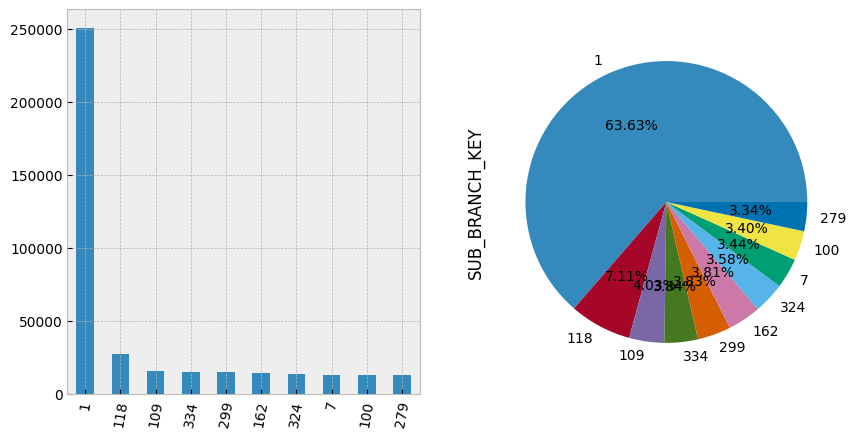

In [29]:
aly_cat_col(df, ['SUB_BRANCH_KEY'])

,default_func,remove_mode_value,logx
count,2154019.000,1794076.000,1794076.000
count_pct_chg,100.000,-16.710,-16.710
mean,45796124.644,50971565.646,17.346
mean_pct_chg,100.000,11.301,-100.000
median,30000000.000,30000000.000,17.217
median_pct_chg,100.000,0.000,-100.000
min,1.000,1.000,0.000
min_pct_chg,100.000,0.000,-100.000
max,5000000000.000,5000000000.000,22.333
max_pct_chg,100.000,0.000,-100.000


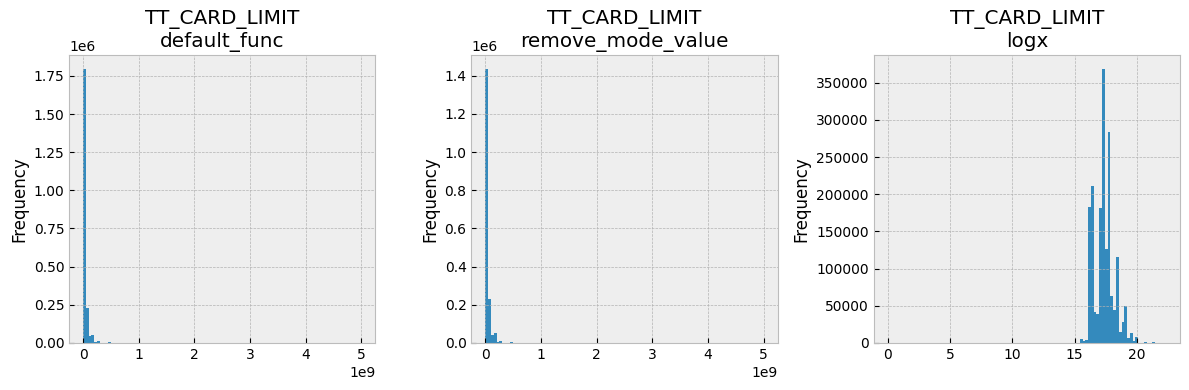

,default_func,remove_mode_value,logx
count,2154019.000,2144132.000,2144132.000
count_pct_chg,100.000,-0.459,-0.459
mean,21501599.456,21599368.671,15.979
mean_pct_chg,100.000,0.455,-100.000
median,13905000.000,13997843.000,16.454
median_pct_chg,100.000,0.668,-100.000
min,1.000,1.000,0.000
min_pct_chg,100.000,0.000,-100.000
max,3716340093.000,3716340093.000,22.036
max_pct_chg,100.000,0.000,-100.000


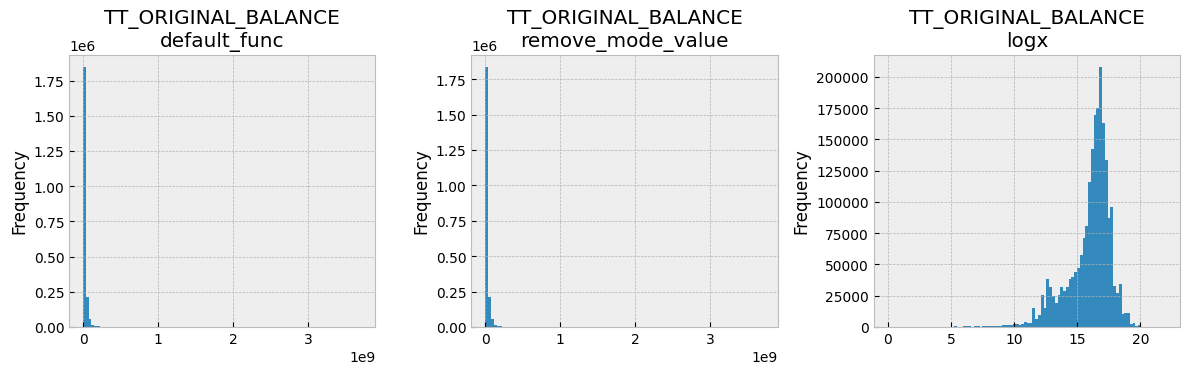

,default_func,remove_mode_value,logx
count,2154019.000,553053.000,553053.000
count_pct_chg,100.000,-74.325,-74.325
mean,4726709.149,18409485.734,16.190
mean_pct_chg,100.000,289.478,-100.000
median,0.000,11360664.000,16.246
median_pct_chg,100.000,inf,inf
min,0.000,193916.000,12.175
min_pct_chg,100.000,inf,inf
max,3265982681.000,3265982681.000,21.907
max_pct_chg,100.000,0.000,-100.000


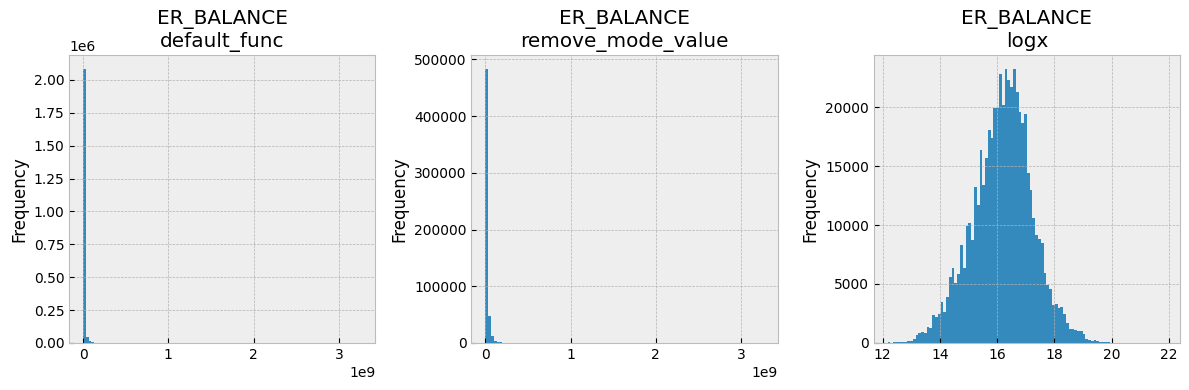

In [34]:
plot_multi_hist_aly(df, ['TT_CARD_LIMIT',
                        'TT_ORIGINAL_BALANCE', 'ER_BALANCE'
                        ])

N1    2095705
N5      19572
N2      16849
N4      13055
N3       8838
Name: TT_LOAN_GROUP, dtype: int64

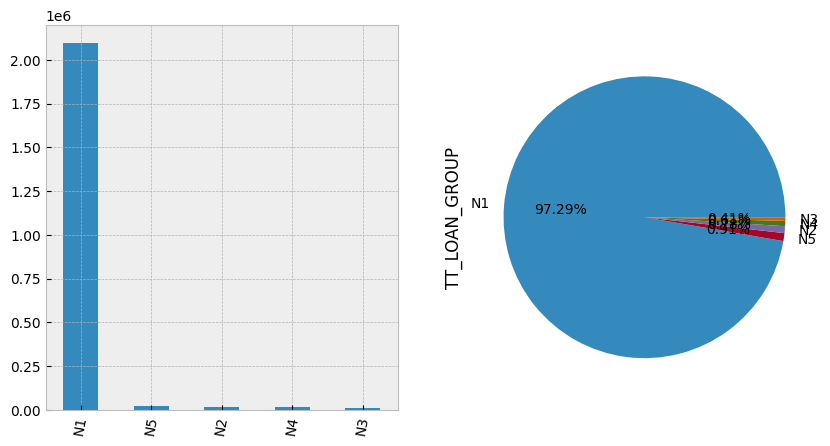

N1    2095705
N5      19572
N2      16849
N4      13055
N3       8838
Name: TRACELOANGROUP, dtype: int64

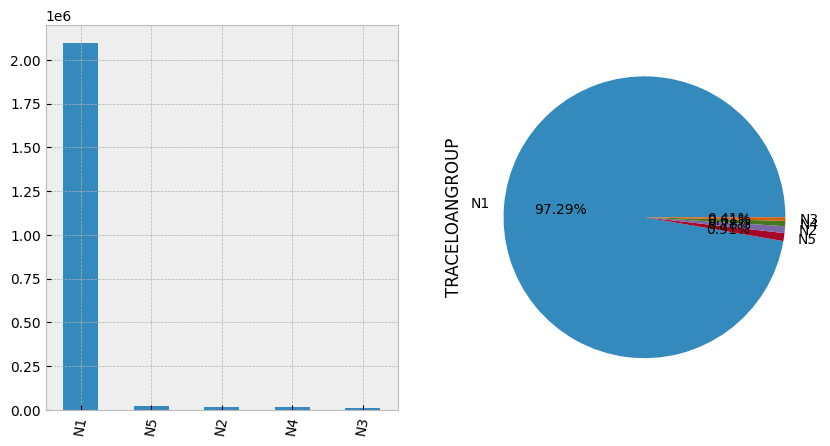

In [36]:
aly_cat_col(df, ['TT_LOAN_GROUP', 'TRACELOANGROUP'])

     2053531
O     100434
L         53
U          1
Name: CB_PLASTIC_CD, dtype: int64

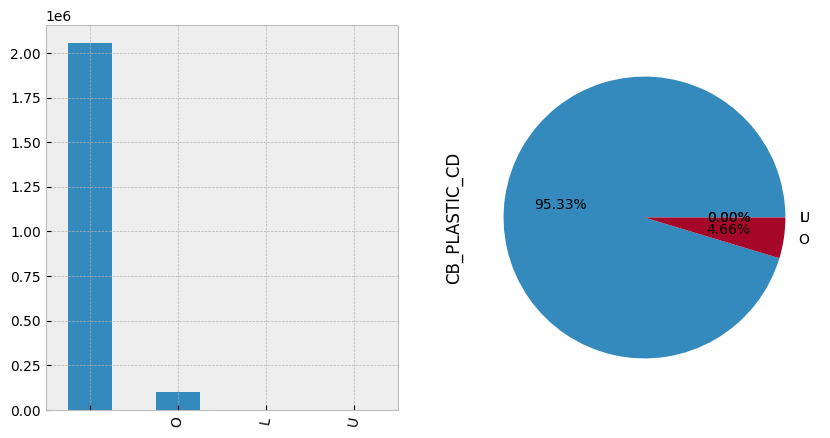

In [37]:
aly_cat_col(df, ['CB_PLASTIC_CD'])

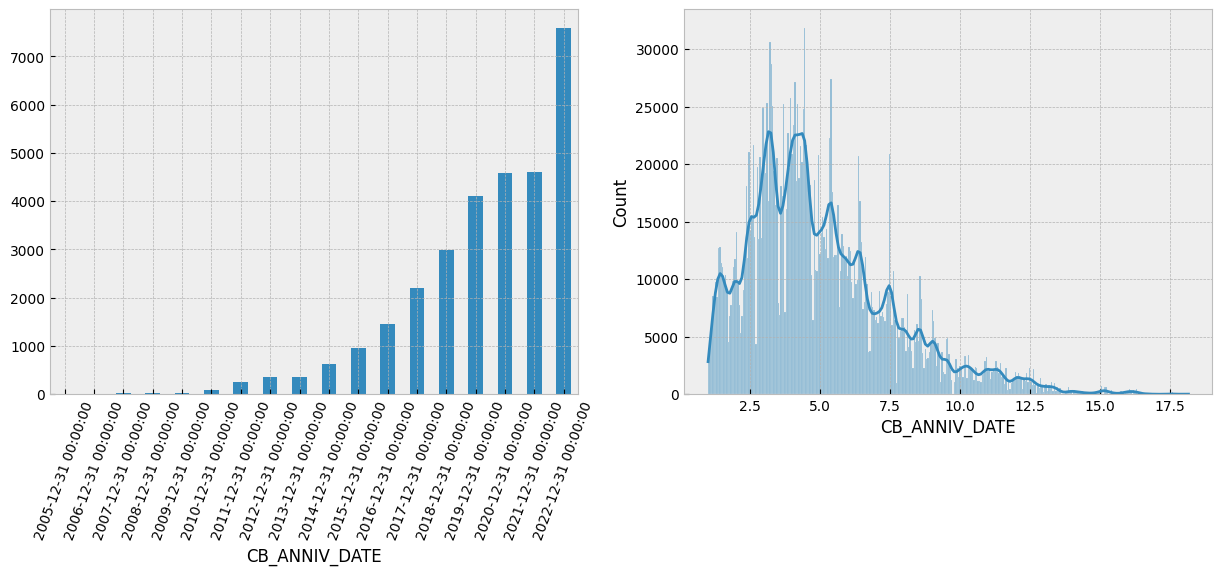

In [38]:
aly_datetime(df,'CB_ANNIV_DATE', 'CUSTOMER_CDE')

0A    334292
03    297675
0F    217341
0G    200040
38    185079
       ...  
48        29
80        17
82         9
15         8
86         5
Name: TT_CUSTOMER_POLICY, Length: 71, dtype: int64

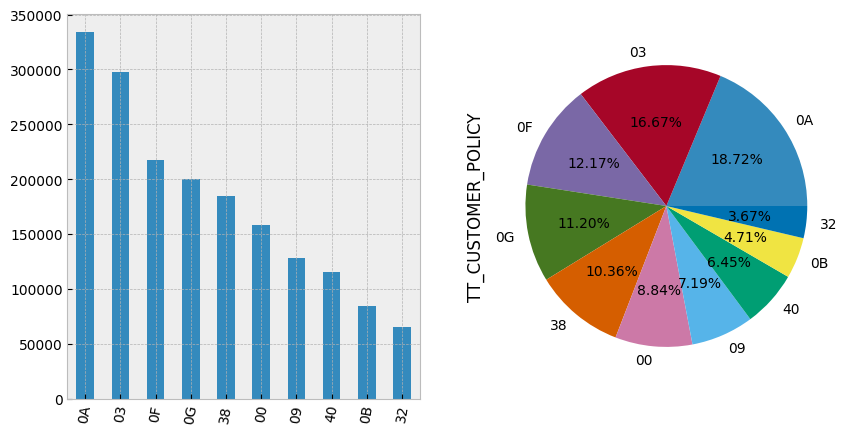

In [40]:
aly_cat_col(df, ['TT_CUSTOMER_POLICY'])

     1928524
C     163140
R      41465
S      12925
V       7924
L         41
Name: CB_STATUS_CD, dtype: int64

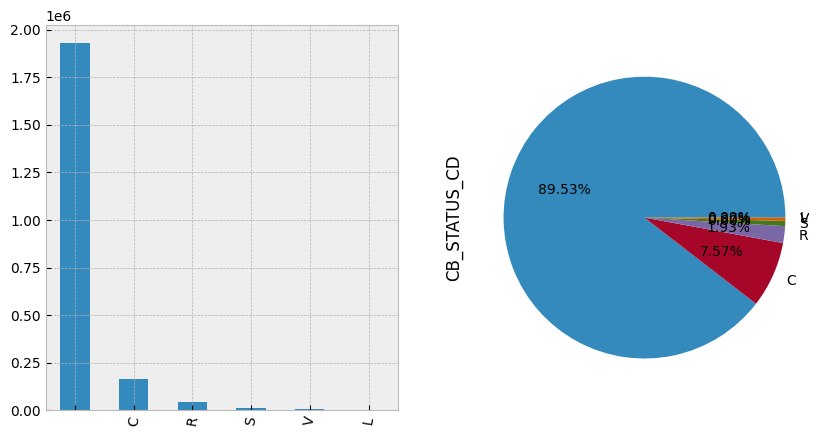

In [42]:
aly_cat_col(df, ['CB_STATUS_CD'])

,default_func,remove_mode_value,logx
count,2150568.000,1438695.000,1438695.000
count_pct_chg,100.000,-33.102,-33.102
mean,452689.855,676682.907,12.466
mean_pct_chg,100.000,49.480,-99.997
median,100000.000,204180.000,12.227
median_pct_chg,100.000,104.180,-99.988
min,0.000,1.000,0.000
min_pct_chg,100.000,inf,NaN
max,309000000.000,309000000.000,19.549
max_pct_chg,100.000,0.000,-100.000


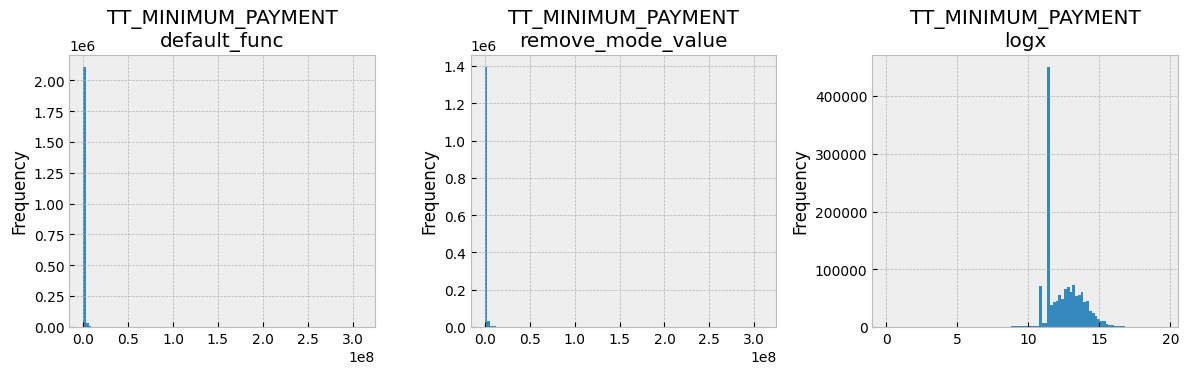

/opt/bitnami/miniconda/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,default_func,remove_mode_value,logx
count,2154019.000,827335.000,827335.000
count_pct_chg,100.000,-61.591,-61.591
mean,27.499,21.564,-inf
mean_pct_chg,100.000,-21.583,-inf
median,31.200,24.600,3.203
median_pct_chg,100.000,-21.154,-89.735
min,0.000,0.000,-inf
min_pct_chg,100.000,NaN,-inf
max,31.200,28.800,3.360
max_pct_chg,100.000,-7.692,-89.230


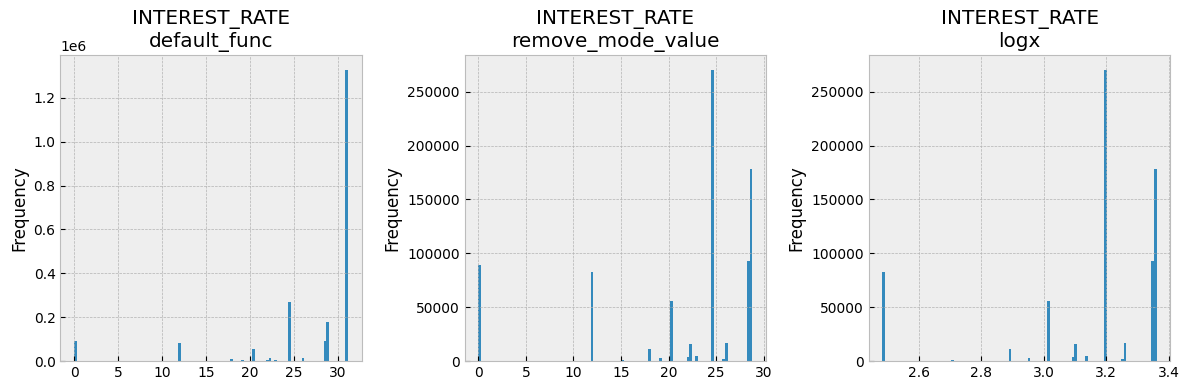

In [43]:
plot_multi_hist_aly(df, ['TT_MINIMUM_PAYMENT', 'INTEREST_RATE'])

In [44]:
df.columns

Index(['CARD_CDE', 'COMPANY_KEY', 'COMPANY_CDE', 'DAY_KEY', 'SUB_BRANCH_KEY',
       'SUB_BRANCH_CDE', 'CUSTOMER_KEY', 'CUSTOMER_CDE', 'CURRENCY_CDE',
       'PRODUCT_CDE', 'TT_CUSTOMER_ID', 'TT_CARD_LIMIT', 'TT_ORIGINAL_BALANCE',
       'ER_BALANCE', 'TT_LOAN_GROUP', 'TRACELOANGROUP', 'LOANGROUPEXT',
       'TRACELOANGROUPEXT', 'TT_BRANCH_CODE', 'CB_USER_FIELD_2',
       'CB_PLASTIC_CD', 'CB_ANNIV_DATE', 'RECOMMENDER_NO',
       'TT_CUSTOMER_POLICY', 'CB_ACTIVATION', 'CORPCUSTID', 'FIN_ACCTNO',
       'TT_KPIBRANCH', 'CB_STATUS_CD', 'TT_MINIMUM_PAYMENT', 'TT_AGE_CODE',
       'TT_BILLING_CYCLE', 'PROCDATE', 'OS_AMT', 'OS_AMT_LCL',
       'TT_CUSTOMER_NAME', 'TT_CUSTOMER_ADDR', 'TT_CARD_NUMBER', 'PROCESS_DT',
       'TT_LOANBRANCH', 'INTEREST_RATE'],
      dtype='object')

## COMPARE SAMPLES - SUB1/2/3